**Quick draw Recogniztion**

# AI Spring 2022 Final Project 

### Examples:
>https://www.kaggle.com/code/kotarojp/first-step-for-submission-keras-resnet50/notebook

>https://www.kaggle.com/code/gaborfodor/greyscale-mobilenet-lb-0-892






# 1. Install modules



In [1]:
#!pip install tensorflow
import tensorflow as tf
print('Using tensorflow version: ', tf.__version__)

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import ast
import random
import cv2
import matplotlib.pyplot as plt
import gc
import json
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using tensorflow version:  2.9.1


In [2]:
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1 Pro



2022-06-09 00:01:15.737769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 00:01:15.737868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 2. Preprocess Data

- Saved train_simplified directory in Google Drive.
- Total 340 classes of picture, each with at least 120 thousands data.
- To avoid long time training, we may choose only a part of them.

In [3]:
dir = os.path.join(os.getcwd(), 'train_simplified')

csv_paths = []
labels = []
count = 0
for file in os.listdir(dir):
  labels.append(file.split('.')[0])

dir = os.path.join(os.getcwd(), 'shuffled')
for file in os.listdir(dir):
    csv_paths.append(os.path.join(dir, file))

csv_paths.sort()
print(csv_paths[-1])
 

/Users/chenvincent/Desktop/110下/Intro to AI/AI_Final/shuffled/valid_data.csv


# 3. Build Model 
- MobileNet

### Hyperparameters

In [4]:
BATCH_SIZE = 680
EPOCHS = 15
BASE_IMG_SIZE = 256
IMG_SIZE = 64

STEP_PER_EPOCH = 500

NUM_CLASS = 340
IMAGE_PER_CLASS = 10


### Create Model

In [5]:
def top_3_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_1_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=1)

In [6]:
model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 1), alpha=1, weights=None, classes=NUM_CLASS)
model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=[categorical_crossentropy, top_1_accuracy, top_3_accuracy])


2022-06-09 00:01:15.759255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 00:01:15.759274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Show Model Structure

In [7]:
# print(model.summary())

# 4. Create One Hot Encoder

In [8]:
wordEncoder = LabelEncoder()
wordEncoder.fit(labels)

def oneHotEncoder(word):
  return to_categorical(wordEncoder.transform([word]), num_classes=NUM_CLASS).reshape((NUM_CLASS,1)) #ugly

# test_y = oneHotEncoder('The Eiffel Tower')
# print(test_y)
# b = [5]
# print(to_categorical(b, 6).reshape(6))
# print(wordEncoder.transform(['arm', 'asparagus', 'axe']))

# 5. Create Train Data Generator

In [17]:
def draw_image_cv2(strokes, img_size, thickness=6, time_color=True):
  img = np.zeros((BASE_IMG_SIZE, BASE_IMG_SIZE), np.uint8)
  for t, stroke in enumerate(strokes):
    for i in range(len(stroke[0])-1):
      color = 255 - min(t, 10) * 13 if time_color else 255
      _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]),color, thickness)
  
  if img_size != BASE_IMG_SIZE:
    return cv2.resize(img, (img_size, img_size))
  else: 
    return img

def training_data_generator(batch_size, img_size, num_class, thickness=6, time_color=True):
  while True:
    x = np.zeros((batch_size, img_size, img_size, 1))
    y = np.zeros((batch_size, NUM_CLASS, 1))
    df = pd.read_csv(random.choice(csv_paths[0:-2])).sample(n=batch_size)
    df['drawing'] = df['drawing'].apply(json.loads)
    for k, raw_strokes in enumerate(df['drawing']):
        x[k, :, :, 0] = draw_image_cv2(raw_strokes, img_size,thickness=6, time_color=False)
        y[k, :, :] = oneHotEncoder(df['word'].iloc[k])
    x = preprocess_input(x).astype(np.float32)
    yield x, y

def df_to_images(df, img_size, thickness=6, time_color=True):
  x = np.zeros((len(df), img_size, img_size, 1))
  df['drawing'] = df['drawing'].apply(json.loads)
  for i , raw_strokes in enumerate(df['drawing']):
    x[i, :, :, 0] = draw_image_cv2(raw_strokes, img_size = img_size)
  # for k, raw_strokes in enumerate(df['drawing']):
  #       print(type(raw_strokes))
  #       raw_strokes = json.loads(raw_strokes)
  #       print(type(raw_strokes))
  #       x[i*IMAGE_PER_CLASS+k, :, :, 0] = draw_image_cv2(raw_strokes, img_size)
  x = preprocess_input(x).astype(np.float32)
  return x

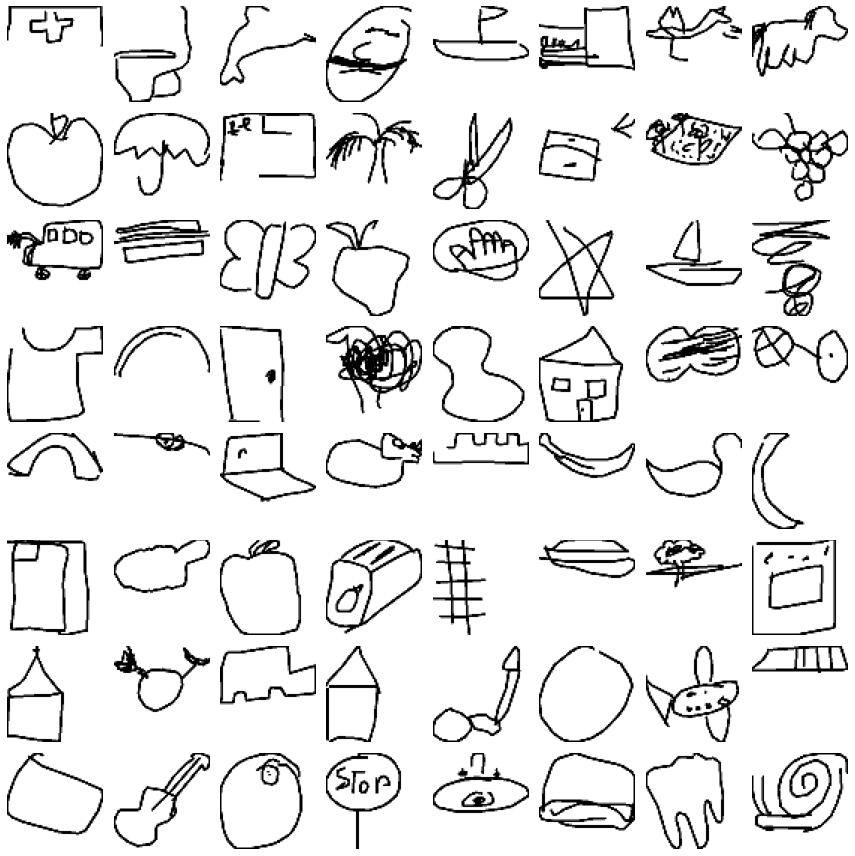

In [10]:
train_datagen = training_data_generator(batch_size = BATCH_SIZE, img_size = IMG_SIZE, num_class=340, time_color=False)

x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();


# 6. Create Validation Data

In [11]:
def create_validation_set(class_num, img_size, thickness=6, time_color=True):
  
    x = np.zeros((80000, img_size, img_size, 1))
    y = np.zeros((80000, NUM_CLASS, 1))

    df = pd.read_csv(csv_paths[-1]) 
    df['drawing'] = df['drawing'].apply(json.loads)
    print(csv_paths[-1])
    for k, raw_strokes in enumerate(df['drawing']):
        x[k,:,:,0] = draw_image_cv2(raw_strokes, img_size, thickness=thickness, time_color=time_color)
        y[k,:,:] = oneHotEncoder(df['word'].iloc[k])
    x = preprocess_input(x).astype(np.float32)
    del(df)
    gc.collect()
    return x, y

In [12]:
x_valid, y_valid = create_validation_set(NUM_CLASS, IMG_SIZE, 6, False)
print(x_valid.shape, y_valid.shape)


/Users/chenvincent/Desktop/110下/Intro to AI/AI_Final/shuffled/valid_data.csv
(80000, 64, 64, 1) (80000, 340, 1)


# 7. Training

In [13]:
callbacks = [
             ReduceLROnPlateau(monitor="val_top_3_accuracy", factor = 0.75, patience = 2, min_delta=0.001,mode='max', min_lr=1e-5, verbose=1),
             ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]

In [14]:
histories = []
history = model.fit(train_datagen, epochs = EPOCHS, steps_per_epoch=STEP_PER_EPOCH, verbose=1, validation_data=(x_valid, y_valid), callbacks=callbacks)
histories.append(history)
print(histories)

Epoch 1/15


2022-06-09 00:01:38.505128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 00:01:39.450433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 3.3518 - categorical_crossentropy: 3.3518 - top_1_accuracy: 0.2767 - top_3_accuracy: 0.4447

2022-06-09 00:22:18.540223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 1272s 3s/step - loss: 3.3518 - categorical_crossentropy: 3.3518 - top_1_accuracy: 0.2767 - top_3_accuracy: 0.4447 - val_loss: 8.1339 - val_categorical_crossentropy: 8.1339 - val_top_1_accuracy: 0.0032 - val_top_3_accuracy: 0.0120 - lr: 0.0020
Epoch 2/15
500/500 [==============================] - 309s 618ms/step - loss: 1.9160 - categorical_crossentropy: 1.9160 - top_1_accuracy: 0.5339 - top_3_accuracy: 0.7408 - val_loss: 2.7292 - val_categorical_crossentropy: 2.7292 - val_top_1_accuracy: 0.4089 - val_top_3_accuracy: 0.6228 - lr: 0.0020
Epoch 3/15
500/500 [==============================] - 309s 618ms/step - loss: 1.6368 - categorical_crossentropy: 1.6368 - top_1_accuracy: 0.5954 - top_3_accuracy: 0.7906 - val_loss: 2.0383 - val_categorical_crossentropy: 2.0383 - val_top_1_accuracy: 0.5203 - val_top_3_accuracy: 0.7269 - lr: 0.0020
Epoch 4/15
500/500 [==============================] - 308s 617ms/step - loss: 1.4973 - categorical_crossentropy: 1.4

# 8. Learning Curve

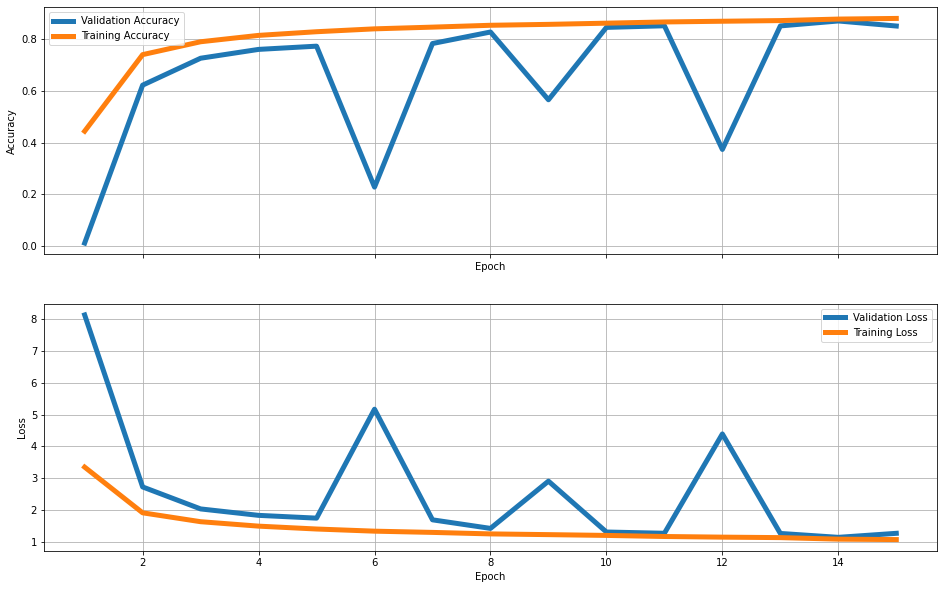

In [15]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in histories], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df['val_top_3_accuracy'], lw=5, label='Validation Accuracy')
axs[0].plot(hist_df['top_3_accuracy'], lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df['val_loss'], lw=5, label='Validation Loss')
axs[1].plot(hist_df['loss'], lw=5, label='Training Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();


# 9. Generate Prediction

In [20]:
test = pd.read_csv(os.path.join(os.getcwd(), 'test_simplified.csv'))
test.head()
x_test = df_to_images(test, IMG_SIZE)
print(test.shape, x_test.shape)

(112199, 3) (112199, 64, 64, 1)
